In [1]:
#importing libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
%matplotlib inline

In [2]:
def noise_removable(img):
    #resizing the image
    img = cv.resize(img,(800,600), interpolation=cv.INTER_AREA)
    image_area = img.shape[0] * img.shape[1]

    plt.imshow(img)
    plt.show()
    #converting into grayscale
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gaussian = cv.GaussianBlur(img_gray, (3,3), 0)
    _, thresh_img = cv.threshold(gaussian, 0, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    
    kernel_er = np.ones((3,3), np.uint8)
    kernel_di = np.ones((3,3), np.uint8)
    img_erosion = cv.erode(thresh_img, kernel_er, iterations=1) 
    img_dilation = cv.dilate(img_erosion, kernel_di, iterations=1)
    
    #finding the boundary of the all threshold images
    contours, _ = cv.findContours(img_dilation, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)   
    for contour in contours:
        #boundary of each contour
        x,y,w,h = cv.boundingRect(contour)
        #to discard very small noises
        if cv.contourArea(contour) < image_area *0.0005:
            img_dilation[y:(y+h),x:(x+w)] = 0
    
    return img_dilation

In [3]:
def ROI(img):
    row, col = img.shape
    check_rows = row // 15
    
    np_gray = np.array(img, np.uint8)
    one_row = np.zeros((1,col), np.uint8)
    
    #list to append the line by single row 
    images_location = []
    
    #arrya to append rows of single segmented words 
    line_seg_img = np.array([])
    
    for r in range(row-1):
        #checking the black colored row or it's the last row
        if np.equal(img[r:(r+1)], one_row).all() or r == row-2:  
            if len(line_seg_img) != 0:
                if line_seg_img.shape[0] > check_rows:
                    images_location.append(line_seg_img[:-1])
                line_seg_img = np.array([])
            
        else:
            #check if the it's first row of the imaged line
            if line_seg_img.size < 1:
                line_seg_img = np.vstack((np_gray[r], np_gray[r+1]))
            
            else:
                line_seg_img = np.vstack((line_seg_img, np_gray[r+1]))
                           

    return images_location

In [4]:
def dikka_remove(img):
    template = []
    row, col = img.shape
    image_size = row * col
    #fitting the imgage with rows
    img_location = ROI(img)   
    #getting the top rows to remove dikka
    extracted_row = row//4
    without_dikka = img_location[0][extracted_row:row+1,:]
    #to find the width of each character
    contours, _ = cv.findContours(without_dikka, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#   print(len(contours))
    for contour in contours[::-1]:
        if cv.contourArea(contour) > image_size*0.01:
            x,y,w,h = cv.boundingRect(contour)
            character = ROI(img_location[0][:,x:x+w])  
            template.append(character[0])
        
    return template

In [ ]:
def preprocessing(img):
    processed_img = noise_removable(img)
    plt.imshow(processed_img, cmap='gray')
    plt.show()

    # Line segmentation
    line_segmentation = ROI(processed_img)
    print(f"Total lines found: {len(line_segmentation)}")
    plt.imshow(line_segmentation[0], cmap='gray')
    plt.show()

    all_words_characters = []  # This will be the final result
    for line_num, line in enumerate(line_segmentation):
        word_segmentations = ROI(line.T)
        print(f"Line {line_num + 1} → Words found: {len(word_segmentations)}")
        for word_num, word in enumerate(word_segmentations):
            word = word.T
            plt.imshow(word, cmap='gray')
            plt.title(f"Line {line_num + 1}, Word {word_num + 1}")
            plt.axis('off')
            plt.show()

            # Character segmentation inside each word
            characters = dikka_remove(np.array(word))
            if characters:  # Only add non-empty character sets
                all_words_characters.append(characters)

                # Show first character
                plt.imshow(characters[0], cmap='gray')
                plt.title("First character of this word")
                plt.show()

    return all_words_characters  # This is: [ [char1, char2, ...], [char1, char2, ...], ... ]


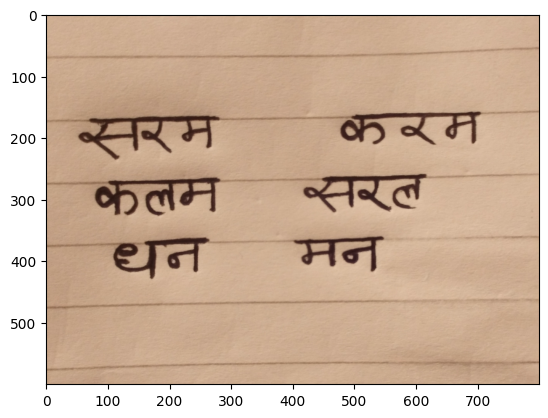

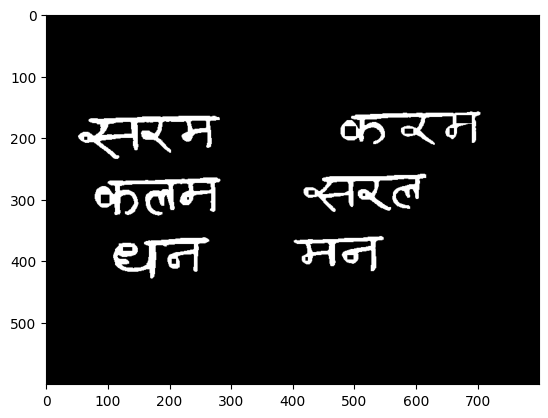

Total lines found: 3


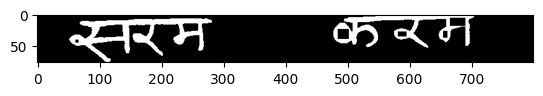

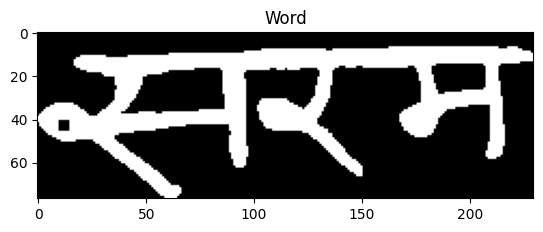

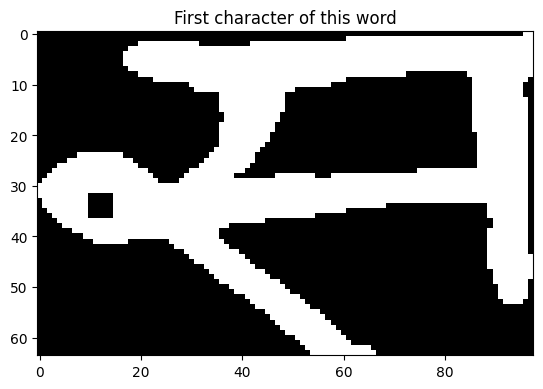

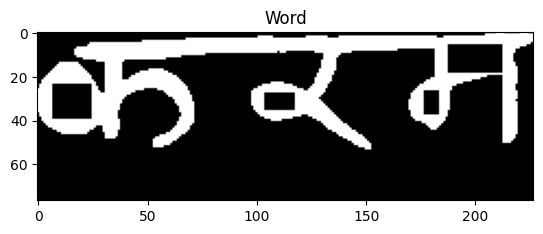

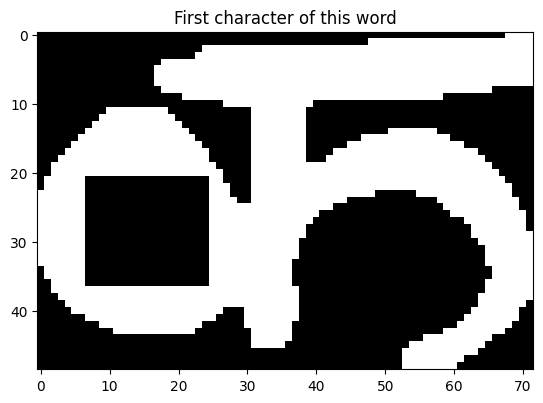

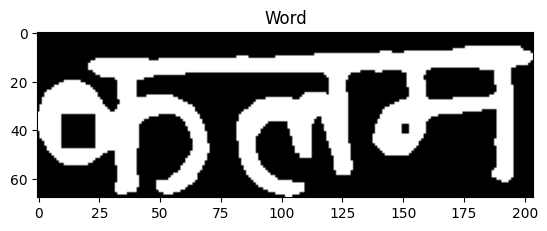

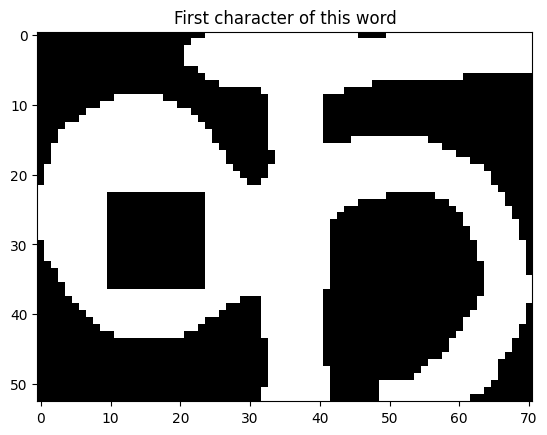

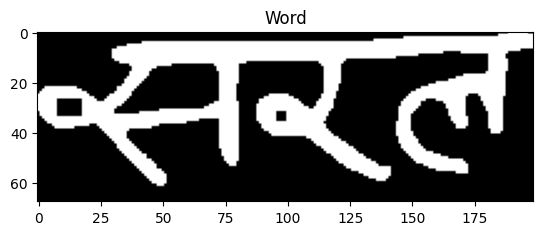

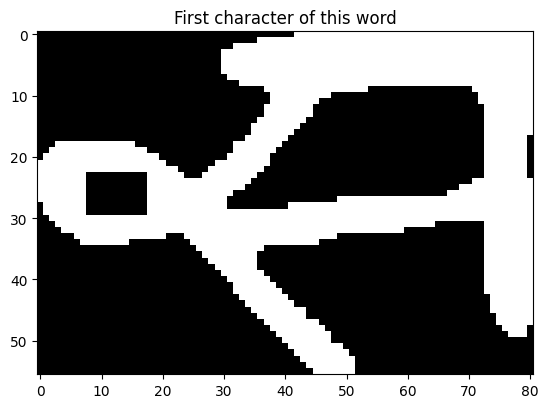

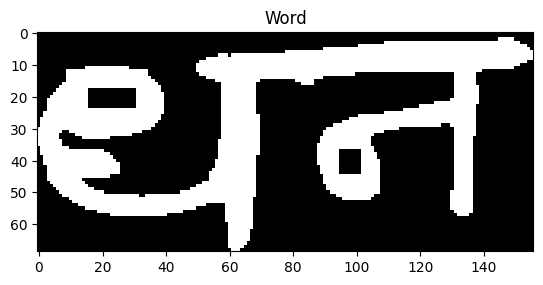

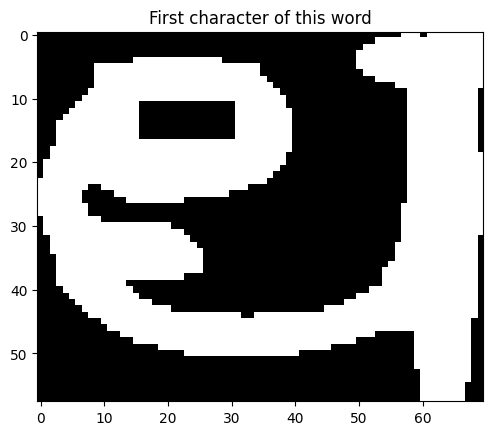

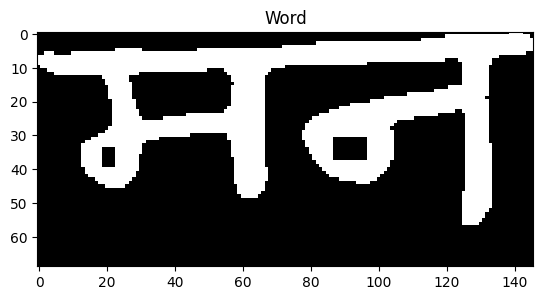

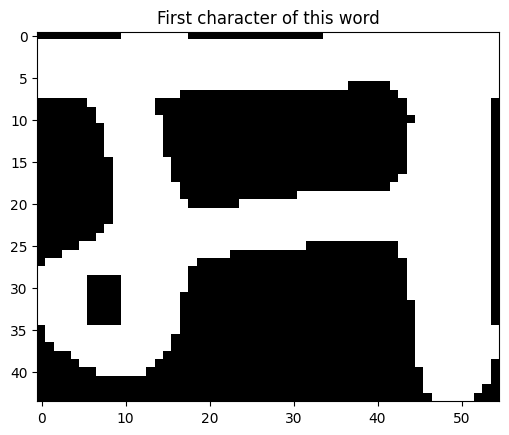

In [6]:
img = cv.imread('OCR_test.jpg')

final_segmented_img = preprocessing(img)

In [7]:

#loading trained model
model = load_model('Handwritten_OCR.keras')

In [8]:
def prediction(final_segmented_img):
    words = len(final_segmented_img)
    accuracy = []

    characters_list = 'ञ,ट,ठ,ड,ढ,ण,त,थ,द,ध,क,न,प,फ,ब,भ,म,य,र,ल,व,ख,श,ष,स,ह,क्ष,त्र,ज्ञ,ग,घ,ङ,च,छ,ज,झ,०,१,२,३,४,५,६,७,८,९'
    characters = characters_list.split(',')

    for i in range(words):
        chars = final_segmented_img[i]
        for img in chars:
            img = np.pad(img, ((2, 2), (2, 2)), mode='constant')  # Padding (top/bottom, left/right)
            img = cv.resize(img, (32, 32), interpolation=cv.INTER_AREA)
            x = np.asarray(img, dtype=np.float32).reshape(1, 32, 32, 1) / 255.0
            
            output = model.predict(x)
            output = output.reshape(46)
            predicted = np.argmax(output)
            devanagari_label = characters[predicted]

            accuracy.append(output[predicted] * 100)
            print(devanagari_label, end='')  # Print character
        
        print(' ', end='')  # Space after each word
    
    return np.mean(accuracy)


In [9]:
accuracy = prediction(final_segmented_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
न 

In [10]:
accuracy

97.13015705347061